In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from gensim.models.word2vec import Word2Vec

### Importing data and preprocessing:

Here the dataset is formed by first combining the main submissions and main comments. The preprocessing steps are:
- the author and subreddit columns are kept
- the deleted and AutoModerator posts are removed
- the first 100,000 rows are kept to improve speed (in the final analyses, all rows will be used for a more thorough analysis)

In [11]:
main1 = pd.read_csv("data\main_submissions.csv", usecols=["author", "subreddit"], dtype={"author": str, "subreddit": str})
main2 = pd.read_csv("data\main_comments.csv", usecols=["author", "subreddit"], dtype={"author": str, "subreddit": str})
dataset = pd.concat([main1, main2])
dataset = dataset[(dataset["author"] != "Io99IHkg-4QzX6xbKwbte0cuzp4=") & (dataset["author"] != "EA1r-K5p_lVBLesLhCFRrKOPN-I=")]
dataset = dataset.head(100000)
dataset.head(10)

,author,subreddit
0,ZkakZ8xfXNiL6wUXhJhRU3Ysa7c=,AskReddit
1,pQ8j9hcuty1RBfCkUutL0cy9Zco=,pics
2,GH3YzjQCtBT4DkTjcxWb2-vPoa0=,Market76
3,57zAuZ7GS2EvQeCSXqU19wYZgjs=,funny
4,HY8UtHbd9PNUDFmaAkm4-10hgmA=,PrequelMemes
5,9tH33QdJxwKi2qmwYsbGaaEY18s=,politics
6,9tH33QdJxwKi2qmwYsbGaaEY18s=,AskReddit
7,MxOiFAejBYCW5pyC1OqtxxQ6OF0=,AskReddit
8,UYhe6ih-1ivvv0VGI8c2yOnF8M4=,teenagers
9,AtJhCRzBKaitBvgRO9h1ylOdSgc=,FreeKarma4U


### Creating community embeddings:

Note: I did not have too much time to incorporate the community embedding from the paper, so I am using the community embedding I began working on during this stage of the analysis.

The first dataframe contains each unique author and their list of subreddits as a string (which will be used later). The second dataframe contains the list of subreddits in list form, and is ready to be used to create the word2vec model.

In [12]:
# notes: sr stands for subreddit, pp stands for preprocessed
author_srs = dataset.groupby("author")["subreddit"].apply(' '.join).reset_index(name="subreddit")
author_srs_pp = dataset.groupby("author")["subreddit"].apply(list).reset_index(name="subreddit")["subreddit"]

Here the model is created and tested with the news subreddit.

In [13]:
model = Word2Vec(author_srs_pp)
model.wv.most_similar(positive=['news'])

[('Games', 0.9561716318130493),
 ('gaming', 0.8900212645530701),
 ('ukpolitics', 0.6957810521125793),
 ('pokemontrades', 0.6832767724990845),
 ('RoastMe', 0.6748286485671997),
 ('CryptoCurrency', 0.67280513048172),
 ('europe', 0.6646226048469543),
 ('Animemes', 0.6571636199951172),
 ('de', 0.6562094688415527),
 ('Coronavirus', 0.6484489440917969)]

A function to obtain a vector from a subreddit is created, which will be used in later steps.

In [14]:
def srs_to_vectors(text):
    return [model.wv[w] for w in text if w in model.wv]

### Calculating GS scores for each user:

The center of mass for each user and then the GS score for each user are calculated.

In [15]:
u_i = []
gs_i = []

# calculating center of mass values
for (i, row) in enumerate(author_srs_pp):
    u_i.append(sum(srs_to_vectors(row)))

# calculating GS score values
for (i, row) in enumerate(author_srs_pp):
    if (len(srs_to_vectors(row)) != 0):
        gs_i.append(sum(list(map(lambda x: (np.dot(x, u_i[i]))/np.linalg.norm(u_i[i]), srs_to_vectors(row))))/len(srs_to_vectors(row)))
    else:
        gs_i.append(pd.NA)

author_srs = author_srs.assign(cm = u_i)
author_srs = author_srs.assign(gs_score = gs_i)

# transforming values to match the definition of GS score
scaler = MinMaxScaler(feature_range=(-1, 1))
author_srs.loc[~author_srs["gs_score"].isna(), "gs_score"] = \
    list(map(lambda x: -x[0], scaler.fit_transform(author_srs[~author_srs["gs_score"].isna()][["gs_score"]])))

author_srs["gs_score"].head(10)

0    0.700197
1    0.826300
2    0.782926
3    0.689974
4    0.664074
5    0.794802
6    0.819195
7    0.779312
8    0.592650
9    0.710361
Name: gs_score, dtype: float64

### Calculating GS scores for each subreddit:

The GS scores are for each subreddit are calculated using the GS scores for each user in the subreddit.

In [16]:
author_gs_dict = pd.Series(author_srs["gs_score"].values, index=author_srs["author"]).to_dict()
sr_authors = dataset.groupby("subreddit")["author"].apply(list).reset_index(name="authors")

gs_j = []
for (i, row) in enumerate(sr_authors["authors"]):
  gs_j.append(np.mean(list(map(lambda x: author_gs_dict[x], row))))

sr_authors = sr_authors.assign(gs_score = gs_j)
sr_gs_dict = pd.Series(sr_authors["gs_score"].values, index=sr_authors["subreddit"]).to_dict()

sr_authors["gs_score"].head(10)

0    0.760746
1    0.788354
2    0.783131
3    0.757876
4    0.795412
5    0.781923
6    0.791470
7    0.709881
8    0.799660
9    0.755341
Name: gs_score, dtype: float64

### GS score distribution for topics related to "news":

The gs_dist function takes a subreddit as input and returns the most similar subreddits with their corresponding GS scores (sorted by GS score). We test it with the news subreddit.

In [17]:
def gs_dist(topic):
    topics = model.wv.most_similar(positive=[topic])
    topics = list(map(lambda x: x[0], topics))
    gs_scores = list(map(lambda x: sr_gs_dict[x] if x in sr_gs_dict else 0, topics))
    dist = pd.DataFrame({"topic": topics, "gs_score": gs_scores})
    return dist.sort_values(by="gs_score", ascending=False)

gs_dist("news")

,topic,gs_score
5,CryptoCurrency,0.817472
7,Animemes,0.795412
4,RoastMe,0.779678
3,pokemontrades,0.770844
9,Coronavirus,0.723902
8,de,0.692864
6,europe,0.687313
1,gaming,0.678487
2,ukpolitics,0.565514
0,Games,0.533908


Here, we plot the GS score distribution for the similar topics.

<AxesSubplot: >

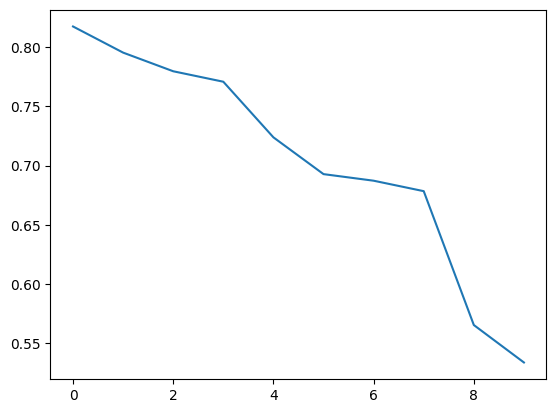

In [18]:
gs_dist("news").reset_index()["gs_score"].plot()

### Next Steps for Project

1. Completing the analysis for the primary research question by finishing the remaining steps:
 - Incorporating the high fidelity community embedding to obtain accurate GS score distributions.
 - Generalizing for many topics: Here a few more plots will be checked to identify if there is a trend. Once a trend is obtained (e.g. f(x) ~ 1/x)), the average mean squared error of the trend function can be checked for many subreddits to see if it is a good fit.
2. Answering the remaining research questions.